In [10]:
import torch
import os
import numpy as np
from PIL import Image
from torchvision import transforms

In [11]:
# Configuración de directorios
SAVE_DIR = '../../results/bounding/cut_images'
if not os.path.exists(SAVE_DIR):
    os.makedirs(SAVE_DIR)

# Configuración de dispositivo
device = torch.device('cuda' if torch.mps.is_available() else 'cpu')

In [12]:
# Cargar modelos
model_detection = torch.hub.load('ultralytics/yolov5', 'custom', '../../models/bounding/best.pt')
model_classification = torch.load('../../models/classifier/cow_class_model.pth', map_location=device)
model_classification.to(device)
model_classification.eval()

Using cache found in C:\Users\dembo/.cache\torch\hub\ultralytics_yolov5_master
YOLOv5  2024-11-1 Python-3.12.2 torch-2.5.1+cpu CPU

Fusing layers... 
Model summary: 157 layers, 7012822 parameters, 0 gradients, 15.8 GFLOPs
Adding AutoShape... 


CowClassifier(
  (model): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU()
    (8): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (9): Flatten(start_dim=1, end_dim=-1)
    (10): Linear(in_features=100352, out_features=128, bias=True)
    (11): ReLU()
    (12): Dropout(p=0.5, inplace=False)
    (13): Linear(in_features=128, out_features=64, bias=True)
    (14): ReLU()
    (15): Linear(in_features=64, out_features=2, bias=True)
  )
)

In [13]:
# Transformación para el modelo de clasificación
transform_classification = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

# Etiquetas de clase
class_labels = {0: 'vaca_acostada', 1: 'vaca_de_pie'}

In [14]:
def classify_cow_posture(img_pil):
    """
    Classifies whether a cow is standing or lying down
    Args:
        img_pil: PIL Image of the cow
    Returns:
        predicted class label
    """
    try:
        # Preparar la imagen para la clasificación
        img_tensor = transform_classification(img_pil).unsqueeze(0).to(device)
        
        # Realizar la predicción
        with torch.no_grad():
            output = model_classification(img_tensor)
            _, pred_label = output.max(1)
            pred_label = pred_label.item()
            
        return class_labels[pred_label]
    except Exception as e:
        print(f"Error en la clasificación: {e}")
        return "clasificación_fallida"

In [15]:
def crop_and_save_detection(img, detection, filename, detection_index):
    """
    Crops the image according to the bounding box coordinates, classifies the cow's posture, and saves it
    """
    # Convertir coordenadas a enteros
    xmin = int(detection['xmin'])
    ymin = int(detection['ymin'])
    xmax = int(detection['xmax'])
    ymax = int(detection['ymax'])
    
    # Asegurarse de que las coordenadas están dentro de los límites
    xmin = max(0, xmin)
    ymin = max(0, ymin)
    xmax = min(img.shape[1], xmax)
    ymax = min(img.shape[0], ymax)
    
    # Recortar la imagen
    cropped_img = img[ymin:ymax, xmin:xmax]
    
    # Convertir a PIL Image
    cropped_img_pil = Image.fromarray(cropped_img)
    
    # Clasificar la postura de la vaca
    posture = classify_cow_posture(cropped_img_pil)
    
    # Generar nombre del archivo incluyendo la postura
    base_name = os.path.splitext(filename)[0]
    save_name = f"{base_name}_detection_{detection_index}_{posture}.jpg"
    save_path = os.path.join(SAVE_DIR, save_name)
    
    # Guardar la imagen
    cropped_img_pil.save(save_path)
    print(f"Imagen guardada: {save_path} - Postura: {posture}")
    
    return posture

In [16]:
def calculate_centroid(xmin, ymin, xmax, ymax):
    """
    Calculates the centroid of a given bounding box's coordinates
    Args:
        xmin: The x position of the bottom left point
        ymin: The y position of the bottom left point
        xmax: The x position of the top right point
        ymax: The y position of the top right point
    Returns:
        The centroid of the given coordinates
    """
    return [(xmax + xmin) / 2, (ymax + ymin) / 2]

In [17]:
def detect_objects(directory):
    """
    Performs object detection and posture classification on the specified images
    """
    predictions = {}
    posture_counts = {'vaca_acostada': 0, 'vaca_de_pie': 0, 'clasificación_fallida': 0}
    
    for filename in os.listdir(directory):
        if filename.endswith(('.png', '.jpg', '.jpeg')):
            img_path = os.path.join(directory, filename)
            original_img = np.array(Image.open(img_path))
            
            # Redimensionar para la detección
            img_resized = Image.open(img_path).resize((640, 320))
            img_resized_array = np.array(img_resized)

            # Realizar la detección
            results = model_detection(img_resized_array)
            results_df = results.pandas().xyxy[0]
            
            # Factores de escala
            scale_x = original_img.shape[1] / 640
            scale_y = original_img.shape[0] / 320
            
            detections = []
            print(f"\nProcesando imagen: {filename}")
            
            # Procesar cada detección
            for idx, detection in results_df.iterrows():
                # Ajustar coordenadas a escala original
                xmin = detection['xmin'] * scale_x
                ymin = detection['ymin'] * scale_y
                xmax = detection['xmax'] * scale_x
                ymax = detection['ymax'] * scale_y
                
                centroid = calculate_centroid(xmin, ymin, xmax, ymax)
                
                # Recortar, clasificar y guardar la detección
                posture = crop_and_save_detection(original_img, 
                                                {'xmin': xmin, 'ymin': ymin, 
                                                 'xmax': xmax, 'ymax': ymax}, 
                                                filename, idx)
                
                # Actualizar contadores
                posture_counts[posture] += 1
                
                # Guardar información de la detección
                detection_info = {
                    'xmin': xmin,
                    'ymin': ymin,
                    'xmax': xmax,
                    'ymax': ymax,
                    'centroid_x': centroid[0],
                    'centroid_y': centroid[1],
                    'confidence': detection['confidence'],
                    'class': detection['class'],
                    'name': detection['name'],
                    'posture': posture
                }
                detections.append(detection_info)
                
                print(f"Detección {idx + 1}: "
                      f"BB: ({detection_info['xmin']:.2f}, {detection_info['ymin']:.2f}, "
                      f"{detection_info['xmax']:.2f}, {detection_info['ymax']:.2f}), "
                      f"Centroide: ({detection_info['centroid_x']:.2f}, {detection_info['centroid_y']:.2f}), "
                      f"Confianza: {detection_info['confidence']:.2f}, "
                      f"Postura: {posture}")
            
            predictions[filename] = detections
            results.show()
    
    # Mostrar resumen final
    print("\nResumen de clasificación de posturas:")
    print(f"Total de vacas acostadas: {posture_counts['vaca_acostada']}")
    print(f"Total de vacas de pie: {posture_counts['vaca_de_pie']}")
    if posture_counts['clasificación_fallida'] > 0:
        print(f"Clasificaciones fallidas: {posture_counts['clasificación_fallida']}")
    
    return predictions

C:\Users\dembo/.cache\torch\hub\ultralytics_yolov5_master\models\common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):



Procesando imagen: val_0.jpg
Imagen guardada: ../../results/bounding/cut_images\val_0_detection_0_vaca_acostada.jpg - Postura: vaca_acostada
Detección 1: BB: (0.00, 73.35, 354.94, 988.61), Centroide: (177.47, 530.98), Confianza: 0.72, Postura: vaca_acostada
Imagen guardada: ../../results/bounding/cut_images\val_0_detection_1_vaca_acostada.jpg - Postura: vaca_acostada
Detección 2: BB: (319.97, 162.13, 776.51, 1054.85), Centroide: (548.24, 608.49), Confianza: 0.58, Postura: vaca_acostada


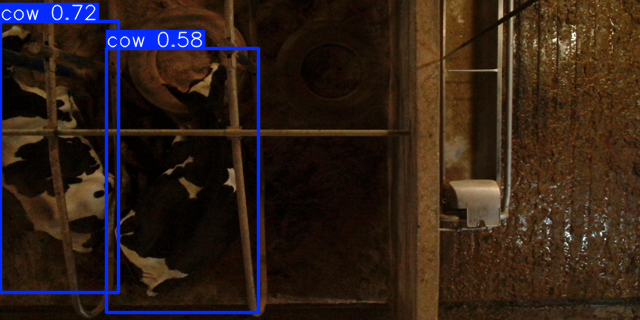

C:\Users\dembo/.cache\torch\hub\ultralytics_yolov5_master\models\common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):



Procesando imagen: val_1.jpg
Imagen guardada: ../../results/bounding/cut_images\val_1_detection_0_vaca_de_pie.jpg - Postura: vaca_de_pie
Detección 1: BB: (215.15, 378.98, 740.33, 1056.07), Centroide: (477.74, 717.52), Confianza: 0.64, Postura: vaca_de_pie


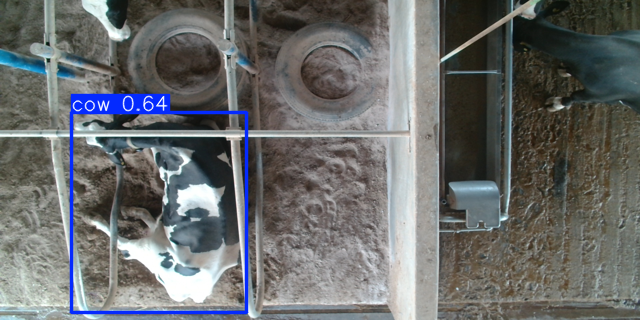

C:\Users\dembo/.cache\torch\hub\ultralytics_yolov5_master\models\common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):



Procesando imagen: val_2.jpg
Imagen guardada: ../../results/bounding/cut_images\val_2_detection_0_vaca_acostada.jpg - Postura: vaca_acostada
Detección 1: BB: (316.69, 104.82, 769.02, 856.74), Centroide: (542.85, 480.78), Confianza: 0.72, Postura: vaca_acostada
Imagen guardada: ../../results/bounding/cut_images\val_2_detection_1_vaca_de_pie.jpg - Postura: vaca_de_pie
Detección 2: BB: (749.56, 278.46, 1123.77, 905.95), Centroide: (936.67, 592.20), Confianza: 0.35, Postura: vaca_de_pie


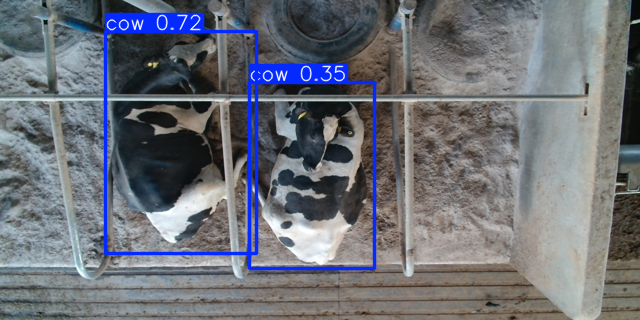

C:\Users\dembo/.cache\torch\hub\ultralytics_yolov5_master\models\common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):



Procesando imagen: val_3.jpg
Imagen guardada: ../../results/bounding/cut_images\val_3_detection_0_vaca_de_pie.jpg - Postura: vaca_de_pie
Detección 1: BB: (0.00, 151.21, 297.40, 1080.00), Centroide: (148.70, 615.60), Confianza: 0.75, Postura: vaca_de_pie
Imagen guardada: ../../results/bounding/cut_images\val_3_detection_1_vaca_acostada.jpg - Postura: vaca_acostada
Detección 2: BB: (740.14, 85.87, 1162.73, 1031.02), Centroide: (951.44, 558.44), Confianza: 0.58, Postura: vaca_acostada
Imagen guardada: ../../results/bounding/cut_images\val_3_detection_2_vaca_acostada.jpg - Postura: vaca_acostada
Detección 3: BB: (309.52, 174.38, 798.68, 881.15), Centroide: (554.10, 527.76), Confianza: 0.35, Postura: vaca_acostada


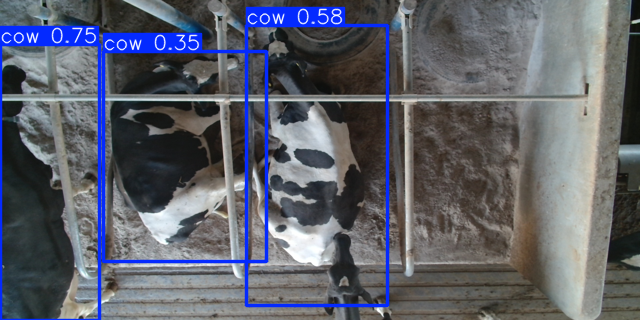

C:\Users\dembo/.cache\torch\hub\ultralytics_yolov5_master\models\common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):



Procesando imagen: val_4.jpg
Imagen guardada: ../../results/bounding/cut_images\val_4_detection_0_vaca_de_pie.jpg - Postura: vaca_de_pie
Detección 1: BB: (783.76, 87.43, 1205.14, 895.54), Centroide: (994.45, 491.48), Confianza: 0.61, Postura: vaca_de_pie
Imagen guardada: ../../results/bounding/cut_images\val_4_detection_1_vaca_de_pie.jpg - Postura: vaca_de_pie
Detección 2: BB: (95.78, 0.00, 759.79, 860.25), Centroide: (427.78, 430.12), Confianza: 0.46, Postura: vaca_de_pie


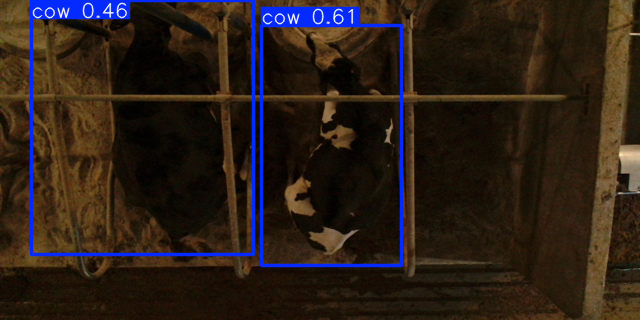

C:\Users\dembo/.cache\torch\hub\ultralytics_yolov5_master\models\common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):



Procesando imagen: val_5.jpg
Imagen guardada: ../../results/bounding/cut_images\val_5_detection_0_vaca_acostada.jpg - Postura: vaca_acostada
Detección 1: BB: (1285.45, 11.77, 1920.00, 818.23), Centroide: (1602.73, 415.00), Confianza: 0.79, Postura: vaca_acostada
Imagen guardada: ../../results/bounding/cut_images\val_5_detection_1_vaca_de_pie.jpg - Postura: vaca_de_pie
Detección 2: BB: (1.06, 3.59, 323.46, 461.83), Centroide: (162.26, 232.71), Confianza: 0.32, Postura: vaca_de_pie


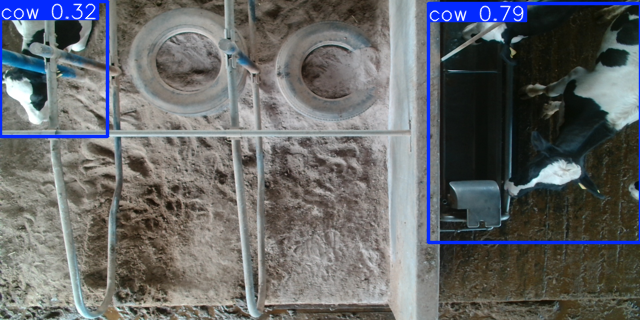

C:\Users\dembo/.cache\torch\hub\ultralytics_yolov5_master\models\common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):



Procesando imagen: val_6.jpg
Imagen guardada: ../../results/bounding/cut_images\val_6_detection_0_vaca_acostada.jpg - Postura: vaca_acostada
Detección 1: BB: (1291.77, 20.10, 1920.00, 802.22), Centroide: (1605.88, 411.16), Confianza: 0.67, Postura: vaca_acostada
Imagen guardada: ../../results/bounding/cut_images\val_6_detection_1_vaca_de_pie.jpg - Postura: vaca_de_pie
Detección 2: BB: (120.49, 304.65, 701.38, 1075.94), Centroide: (410.93, 690.29), Confianza: 0.59, Postura: vaca_de_pie


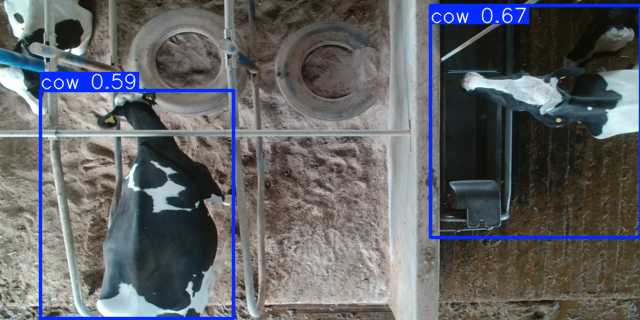


Resumen de clasificación de posturas:
Total de vacas acostadas: 7
Total de vacas de pie: 7


In [18]:
DIRECTORY = '../../dataset/bounding/detect/'

# Ejecutar la detección y obtener los resultados
results = detect_objects(DIRECTORY)